### MORANv2 evaluation on datasets from the arXiv paper: https://arxiv.org/pdf/1901.03003.pdf

Import MORAN:

In [1]:
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
%matplotlib inline

import torch
from torch.autograd import Variable

import tools.utils as utils
import tools.dataset as dataset

from models.moran import MORAN

Loading MORAN model:

In [2]:
model_path = './demo.pth'
img_path = './demo/0.png'
alphabet = '0:1:2:3:4:5:6:7:8:9:a:b:c:d:e:f:g:h:i:j:k:l:m:n:o:p:q:r:s:t:u:v:w:x:y:z:$'

cuda_flag = False
if torch.cuda.is_available():
    cuda_flag = True
    MORAN_model = MORAN(1, len(alphabet.split(':')), 256, 32, 100, BidirDecoder=True, CUDA=cuda_flag)
    MORAN_model = MORAN_model.cuda()
else:
    MORAN_model = MORAN(1, len(alphabet.split(':')), 256, 32, 100, BidirDecoder=True, inputDataType='torch.FloatTensor', CUDA=cuda_flag)

print('loading pretrained model from %s' % model_path)
if cuda_flag:
    state_dict = torch.load(model_path)
else:
    state_dict = torch.load(model_path, map_location='cpu')
MORAN_state_dict_rename = OrderedDict()
for k, v in state_dict.items():
    name = k.replace("module.", "") # remove `module.`
    MORAN_state_dict_rename[name] = v
MORAN_model.load_state_dict(MORAN_state_dict_rename)

for p in MORAN_model.parameters():
    p.requires_grad = False
MORAN_model.eval()

/home/izakharkin/anaconda3/envs/moran/lib/python3.6/site-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/home/izakharkin/MORAN_v2/models/asrn_res.py:234: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight, mode='fan_out', a=0)
/home/izakharkin/MORAN_v2/models/asrn_res.py:236: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.weight, 1)
/home/izakharkin/MORAN_v2/models/asrn_res.py:237: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias, 0)


loading pretrained model from ./demo.pth


MORAN(
  (MORN): MORN(
    (cnn): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU(inplace)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): ReLU(inplace)
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (9): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace)
      (12): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): BatchNorm2d(16, eps=1e-

* Test inference:

torch.Size([1, 1, 32, 100])
torch.Size([1, 1, 32, 100])
torch.Size([1, 1, 4, 12])
torch.Size([1, 1, 3, 11])
torch.Size([1, 1, 32, 100])
torch.Size([1, 1, 32, 100])
CPU times: user 132 ms, sys: 12 ms, total: 144 ms
Wall time: 152 ms

Result:
Left to Right: jewelers
Right to Left: srelewej




/home/izakharkin/anaconda3/envs/moran/lib/python3.6/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/izakharkin/anaconda3/envs/moran/lib/python3.6/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/izakharkin/anaconda3/envs/moran/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


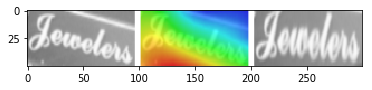

In [3]:
converter = utils.strLabelConverterForAttention(alphabet, ':')
transformer = dataset.resizeNormalize((100, 32))
image = Image.open(img_path).convert('L')
image = transformer(image)

if cuda_flag:
    image = image.cuda()
image = image.view(1, *image.size())
image = Variable(image)
text = torch.LongTensor(1 * 5)
length = torch.IntTensor(1)
text = Variable(text)
length = Variable(length)

max_iter = 20
t, l = converter.encode('0'*max_iter)
utils.loadData(text, t)
utils.loadData(length, l)

%time output = MORAN_model(image, length, text, text, test=True, debug=True)

preds, preds_reverse = output[0]
demo = output[1]

_, preds = preds.max(1)
_, preds_reverse = preds_reverse.max(1)

sim_preds = converter.decode(preds.data, length.data)
sim_preds = sim_preds.strip().split('$')[0]
sim_preds_reverse = converter.decode(preds_reverse.data, length.data)
sim_preds_reverse = sim_preds_reverse.strip().split('$')[0]

print('\nResult:\n' + 'Left to Right: ' + sim_preds + '\nRight to Left: ' + sim_preds_reverse + '\n\n')
plt.imshow(demo);

### Evalation on datasets:

#### ICDAR 2015 (Robust Recognition Challenge: Incidental Scene Text)

In [5]:
ICDAR15_PATH = '/srv/hd3/data/izakharkin/icdar2015/word_recognition/'
TRAIN_IMG_DIR = 'train_word_images/'
TEST_IMG_DIR = 'test_word_images/'

In [6]:
import os
import glob

train_imgs_list = glob.glob(ICDAR15_PATH+'/'+TRAIN_IMG_DIR+'/*.png')
print('Num train images ', len(train_imgs_list))

Num train images  4468


In [7]:
test_imgs_list = glob.glob(ICDAR15_PATH+'/'+TEST_IMG_DIR+'/*.png')
print('Num test images ', len(test_imgs_list))

Num test images  2077


In [8]:
test_words_gt = ICDAR15_PATH+'/'+'test_words_gt.txt'

img_gt_dict = {}

with open(test_words_gt, 'r') as gt_file:
    for line in gt_file:
        img_name, text = line.split(', ')
        img_gt_dict[img_name] = text.strip()[1:-1]
        print(img_name, img_gt_dict[img_name])

﻿word_1.png JOINT
word_2.png yourself
word_3.png 154
word_4.png 197
word_5.png 727
word_6.png 198
word_7.png 20029
word_8.png Free
word_9.png from
word_10.png PAIN
word_11.png BLOCK
word_12.png 441B
word_13.png STOREY
word_14.png NUS
word_15.png Speed
word_16.png Regulating
word_17.png Strips
word_18.png Ahead
word_19.png SLOW
word_20.png DOORS
word_21.png AIROB
word_22.png Reserved
word_23.png Seating
word_24.png FOR
word_25.png SHOP
word_26.png Kappa
word_27.png CAUTION
word_28.png VEGETARIAN
word_29.png Please
word_30.png lower
word_31.png your
word_32.png volume
word_33.png when
word_34.png you
word_35.png pass
word_36.png residential
word_37.png areas
word_38.png BEWARE
word_39.png MAINTENANCE
word_40.png VEICHLES
word_41.png those
word_42.png need!
word_43.png Care
word_44.png for
word_45.png Look
word_46.png Care
word_47.png CHEVRON
word_48.png Premier
word_49.png HSBC
word_50.png HOU
word_51.png the
word_52.png Future
word_53.png Communications
word_54.png venting
word_55.png n

word_775.png 50%off
word_776.png ORE
word_777.png POP
word_778.png OUR
word_779.png SALE
word_780.png 01-15
word_781.png strip
word_782.png POP
word_783.png OUR
word_784.png SORE
word_785.png #01-15
word_786.png POP
word_787.png OUR
word_788.png ORE
word_789.png AI #
word_790.png Buffet
word_791.png TOAST
word_792.png BreadTalk
word_793.png IND
word_794.png Town
word_795.png Epidor
word_796.png BANGKOKJAM
word_797.png BOX
word_798.png TOAST
word_799.png BOX
word_800.png BEERY
word_801.png THIRSTY?
word_802.png $10
word_803.png FORTWO
word_804.png Epidor
word_805.png Bread
word_806.png Talk
word_807.png Epidor
word_808.png COCOA
word_809.png TREES
word_810.png TOBLERONE
word_811.png m&m
word_812.png Cadbury
word_813.png Everyday
word_814.png Specials
word_815.png PODI
word_816.png COMNAM
word_817.png LONDON
word_818.png Crahtree
word_819.png Evelyn
word_820.png Mt.
word_821.png Sapola
word_822.png MPH
word_823.png BOOKSTORES
word_824.png hair
word_825.png billlie
word_826.png HOUSE
word

word_2048.png PLAZA
word_2049.png CORNER
word_2050.png LORS
word_2051.png Clemenceau
word_2052.png Ave
word_2053.png Havelock
word_2054.png CTE
word_2055.png SLE
word_2056.png Bras
word_2057.png Basah
word_2058.png attached
word_2059.png minimum
word_2060.png strings
word_2061.png spend
word_2062.png earn
word_2063.png cap
word_2064.png Promise
word_2065.png anywhere
word_2066.png 24/7
word_2067.png 365
word_2068.png Cavenagh
word_2069.png KEEP
word_2070.png RIGHT
word_2071.png EXCEPT
word_2072.png TRAFFIC
word_2073.png TURNING
word_2074.png INTO
word_2075.png ISTANA
word_2076.png DOMAIN
word_2077.png Underpass


* Evaluation:

In [9]:
model_path = './demo.pth'
alphabet = '0:1:2:3:4:5:6:7:8:9:a:b:c:d:e:f:g:h:i:j:k:l:m:n:o:p:q:r:s:t:u:v:w:x:y:z:$'

cuda_flag = False
if torch.cuda.is_available():
    cuda_flag = True
    MORAN_model = MORAN(1, len(alphabet.split(':')), 256, 32, 100, BidirDecoder=True, CUDA=cuda_flag)
    MORAN_model = MORAN_model.cuda()
else:
    MORAN_model = MORAN(1, len(alphabet.split(':')), 256, 32, 100, BidirDecoder=True, inputDataType='torch.FloatTensor', CUDA=cuda_flag)

print('loading pretrained model from %s' % model_path)
if cuda_flag:
    state_dict = torch.load(model_path)
else:
    state_dict = torch.load(model_path, map_location='cpu')
MORAN_state_dict_rename = OrderedDict()
for k, v in state_dict.items():
    name = k.replace("module.", "") # remove `module.`
    MORAN_state_dict_rename[name] = v
MORAN_model.load_state_dict(MORAN_state_dict_rename)

for p in MORAN_model.parameters():
    p.requires_grad = False
MORAN_model.eval()

loading pretrained model from ./demo.pth


MORAN(
  (MORN): MORN(
    (cnn): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU(inplace)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): ReLU(inplace)
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (9): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace)
      (12): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): BatchNorm2d(16, eps=1e-

In [11]:
def predict_moran(img_path, model):
    converter = utils.strLabelConverterForAttention(alphabet, ':')
    transformer = dataset.resizeNormalize((100, 32))
    print(img_path)
    image = Image.open(img_path).convert('L')
    image = transformer(image)

    if cuda_flag:
        image = image.cuda()
    image = image.view(1, *image.size())
    image = Variable(image)
    text = torch.LongTensor(1 * 5)
    text = Variable(text)
    length = torch.IntTensor(1)
    length = Variable(length)

    max_iter = 20
    t, l = converter.encode('0'*max_iter)
    utils.loadData(text, t)
    utils.loadData(length, l)

    output = model(image, length, text, text, test=True, debug=True)

    preds, preds_reverse = output[0]
    demo = output[1]

    _, preds = preds.max(1)
    _, preds_reverse = preds_reverse.max(1)

    sim_preds = converter.decode(preds.data, length.data)
    sim_preds = sim_preds.strip().split('$')[0]
    sim_preds_reverse = converter.decode(preds_reverse.data, length.data)
    sim_preds_reverse = sim_preds_reverse.strip().split('$')[0]

    return sim_preds

In [13]:
img_pred_dict = {}

for img_name in img_gt_dict:
    try:
        full_img_name = ICDAR15_PATH+'/'+TEST_IMG_DIR+'/'+img_name
        text_pred = predict_moran(full_img_name, MORAN_model)
        img_pred_dict[img_name] = text_pred
        print(text_pred)
    except FileNotFoundError:
        print('ERROR', img_name)

/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//﻿word_1.png
ERROR ﻿word_1.png
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_2.png
yourself
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_3.png
154
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_4.png
197
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_5.png
727
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_6.png
198
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_7.png
20029
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_8.png
free
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_9.png
from
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_10.png
pain
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_11.png
block
/srv/hd3/data/izakharkin/

i
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_94.png
lines
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_95.png
toffifee
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_96.png
emergency
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_97.png
stop
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_98.png
plunger
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_99.png
convers
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_100.png
fairfrice
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_101.png
finest
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_102.png
mitsubishi
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_103.png
jijp
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_104.png
t

a
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_186.png
8
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_187.png
2
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_188.png
space
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_189.png
samsung
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_190.png
kinokuniya
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_191.png
lianga
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_192.png
manga
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_193.png
pumpkin
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_194.png
the
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_195.png
big
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_196.png
patch
/srv/hd3/d

ceven
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_278.png
takyo
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_279.png
fruit
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_280.png
freshly
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_281.png
cut
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_282.png
loaves
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_283.png
rolls
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_284.png
pastries
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_285.png
for
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_286.png
buy
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_287.png
value
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_288.png
frosh
/srv

pan
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_370.png
hotel
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_371.png
sunted
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_372.png
convention
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_373.png
pacific
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_374.png
centre
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_375.png
longines
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_376.png
sale
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_377.png
saie
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_378.png
sale
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_379.png
sale
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_380.png
dini

speed
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_462.png
eels
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_463.png
algonicolog
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_464.png
marina
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_465.png
mrt
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_466.png
station
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_467.png
link
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_468.png
marina
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_469.png
mr
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_470.png
carti
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_471.png
flan
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_472.png
obi
/srv

city
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_554.png
that
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_555.png
gives
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_556.png
you
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_557.png
sale
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_558.png
further
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_559.png
reductions
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_560.png
giordan
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_561.png
gap
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_562.png
off
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_563.png
off
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_564.png
com
/srv/hd3

noodles
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_646.png
pontian
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_647.png
wanion
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_648.png
open
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_649.png
early
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_650.png
opens
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_651.png
toast
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_652.png
daily
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_653.png
co
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_654.png
your
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_655.png
interlant
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_656.png
dicod


it
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_738.png
lines
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_739.png
added
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_740.png
new
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_741.png
deeigual
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_742.png
further
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_743.png
lixes
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_744.png
sale
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_745.png
50
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_746.png
sales
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_747.png
sale
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_748.png
70
/srv/hd3/dat

are
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_830.png
hosereel
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_831.png
wet
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_832.png
unites
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_833.png
house
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_834.png
esmrt
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_835.png
experience
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_836.png
fibre
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_837.png
here
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_838.png
experience
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_839.png
open
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_840.png
pu

e
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_922.png
aster
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_923.png
til
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_924.png
directory
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_925.png
place
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_926.png
div
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_927.png
theres
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_928.png
always
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_929.png
that
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_930.png
special
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_931.png
the
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_932.png
areas
/srv/hd

theatro
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1014.png
roof
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1015.png
like
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1016.png
nets
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1017.png
axs
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1018.png
kenko
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1019.png
lesharder
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1020.png
flaran
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1021.png
mandarin
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1022.png
oriental
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1023.png
brenner
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//wor

age
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1104.png
peperchi
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1105.png
peperoni
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1106.png
fizzeria
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1107.png
peparan
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1108.png
promod
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1109.png
thank
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1110.png
you
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1111.png
brauk
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1112.png
buffel
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1113.png
gerdano
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//wo

exit
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1194.png
standam
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1195.png
swarovski
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1196.png
diane
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1197.png
furstenderg
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1198.png
maxmara
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1199.png
bally
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1200.png
dior
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1201.png
stage
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1202.png
patek
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1203.png
philippe
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images

your
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1284.png
girls
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1285.png
scotch
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1286.png
soda
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1287.png
austerdan
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1288.png
pening
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1289.png
soon
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1290.png
a
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1291.png
shop
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1292.png
tsic
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1293.png
special
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1294.png


the
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1374.png
soup
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1375.png
spoon
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1376.png
50
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1377.png
off
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1378.png
sale
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1379.png
make
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1380.png
store
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1381.png
northern
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1382.png
store
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1383.png
deathpaning
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1384.png


parking
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1464.png
the
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1465.png
entrance
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1466.png
the
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1467.png
carpark
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1468.png
order
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1469.png
the
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1470.png
management
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1471.png
sale
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1472.png
ale
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1473.png
bille
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1474.

xmas
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1556.png
off
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1557.png
sale
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1558.png
well
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1559.png
win
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1560.png
we
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1561.png
workshope
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1562.png
wilker
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1563.png
hum
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1564.png
workshopher
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1565.png
rauco
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1566.png


deals
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1646.png
sat
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1647.png
alchen
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1648.png
chicken
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1649.png
holiday
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1650.png
platter
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1651.png
50
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1652.png
candy
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1653.png
empire
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1654.png
holiday
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1655.png
platter
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1

luminex
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1736.png
gear
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1737.png
always
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1738.png
visiate
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1739.png
coldwear
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1740.png
coldwear
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1741.png
sale
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1742.png
super
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1743.png
sale
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1744.png
omgi
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1745.png
her
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_174

mortdecal
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1826.png
mortdecal
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1827.png
cathly
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1828.png
cineplexes
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1829.png
january
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1830.png
sophistication
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1831.png
harad
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1832.png
showing
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1833.png
exodus
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1834.png
not
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1835.png
now
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_wo

ebate
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1916.png
sale
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1917.png
naingio
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1918.png
enjoy
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1919.png
here
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1920.png
ocbc
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1921.png
bank
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1922.png
sale
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1923.png
personal
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1924.png
shopping
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1925.png
off
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_1926.pn

the
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_2006.png
reckless
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_2007.png
simpe
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_2008.png
yamano
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_2009.png
face
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_2010.png
the
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_2011.png
acalator
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_2012.png
loccha
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_2013.png
cuse
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_2014.png
6385830
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_2015.png
b139
/srv/hd3/data/izakharkin/icdar2015/word_recognition//test_word_images//word_2016.

In [23]:
pred_texts = np.array(list(img_pred_dict.values()))
pred_texts

array(['yourself', '154', '197', ..., 'isiana', 'domain', 'underpass'],
      dtype='<U18')

In [29]:
gt_texts = np.array(list(map(lambda x: x.lower(), img_gt_dict.values())))
gt_texts

array(['joint', 'yourself', '154', ..., 'istana', 'domain', 'underpass'],
      dtype='<U21')

In [30]:
len(pred_texts)

2076

In [31]:
len(gt_texts)

2077

In [32]:
gt_texts = gt_texts[1:]

In [37]:
total_word_acc_icdar2015 = np.sum(pred_texts == gt_texts) / len(pred_texts)
print(
    'Word accuracy on ICDAR 2015:', 
    round(total_word_acc_icdar2015 * 100, 2), '%'
)

Word accuracy on ICDAR 2015: 68.16 %


* failure with 1 image

#### Street View Text (SVT)

In [90]:
SVT_PATH = '/srv/hd3/data/izakharkin/SVT/svt1/'
TRAIN_WORDS_LIST = 'train.xml'
TEST_WORDS_LIST = 'test.xml'
IMG_DIR = '/img/'
CROP_IMG_DIR = '/cropped_word_imgs/'

In [91]:
import os
import glob

imgs_list = glob.glob(SVT_PATH+'/'+IMG_DIR+'/*.jpg')
print('Num images ', len(imgs_list))

Num images  350


In [96]:
from lxml import etree

with open(SVT_PATH+'/'+TEST_WORDS_LIST) as fobj:
    xml = fobj.read()
    xml = xml.replace('<?xml version="1.0" encoding="utf-8"?>', '')

root = etree.fromstring(xml)

img_gt_dict = {}

for image_name in root.getchildren():
        for elem in image_name.getchildren():
            if elem.tag == 'imageName':
                name = elem.text
                image = plt.imread(SVT_PATH+'/'+name)
                name = name.split('/')[1]
                print(name, 'image shape:', image.shape)
            elif elem.tag == 'taggedRectangles':
                for i, rect in enumerate(elem.getchildren()):
                    h = int(rect.attrib['height'])
                    w = int(rect.attrib['width'])
                    x = int(rect.attrib['x'])
                    y = int(rect.attrib['y'])
                    word_crop_image = image[y:y+h,x:x+w]
                    full_crop_name = CROP_IMG_DIR+'/'+name[:-4]+'_{}'.format(i)+name[-4:]
                    img_gt_dict[full_crop_name] = rect.getchildren()[0].text.strip()
                    try:
                        plt.imsave(SVT_PATH+'/'+full_crop_name, word_crop_image)
                    except SystemError:
                        print('NOO!', name)

18_01.jpg image shape: (800, 1280, 3)
13_11.jpg image shape: (768, 1024, 3)
17_18.jpg image shape: (768, 1024, 3)
06_16.jpg image shape: (1050, 1680, 3)
17_02.jpg image shape: (768, 1024, 3)
03_03.jpg image shape: (896, 1910, 3)
14_07.jpg image shape: (882, 1278, 3)
08_04.jpg image shape: (902, 1280, 3)
19_04.jpg image shape: (1024, 1280, 3)
01_13.jpg image shape: (800, 1280, 3)
17_09.jpg image shape: (768, 1024, 3)
09_12.jpg image shape: (800, 1280, 3)
04_17.jpg image shape: (1024, 1280, 3)
02_13.jpg image shape: (1024, 1280, 3)
13_17.jpg image shape: (768, 1024, 3)
01_17.jpg image shape: (800, 1280, 3)
09_07.jpg image shape: (800, 1280, 3)
18_13.jpg image shape: (800, 1280, 3)
18_06.jpg image shape: (800, 1280, 3)
00_13.jpg image shape: (768, 1024, 3)
00_05.jpg image shape: (768, 1024, 3)
03_12.jpg image shape: (898, 1918, 3)
07_02.jpg image shape: (1024, 1280, 3)
07_03.jpg image shape: (1024, 1280, 3)
18_10.jpg image shape: (800, 1280, 3)
15_03.jpg image shape: (1024, 1280, 3)
15_06

08_17.jpg image shape: (878, 1280, 3)
03_00.jpg image shape: (898, 1918, 3)
09_19.jpg image shape: (800, 1280, 3)
02_17.jpg image shape: (768, 1366, 3)
01_06.jpg image shape: (800, 1280, 3)
03_14.jpg image shape: (906, 1918, 3)
13_01.jpg image shape: (768, 1024, 3)
00_18.jpg image shape: (768, 1024, 3)
09_15.jpg image shape: (800, 1280, 3)
00_04.jpg image shape: (768, 1024, 3)
06_13.jpg image shape: (1050, 1680, 3)
19_03.jpg image shape: (1024, 1280, 3)
03_18.jpg image shape: (900, 1918, 3)
19_00.jpg image shape: (1024, 1280, 3)
09_00.jpg image shape: (800, 1280, 3)
15_05.jpg image shape: (768, 1024, 3)
03_09.jpg image shape: (902, 1920, 3)
11_02.jpg image shape: (800, 1280, 3)
15_04.jpg image shape: (1024, 1280, 3)
11_09.jpg image shape: (800, 1280, 3)
05_15.jpg image shape: (880, 1278, 3)
07_09.jpg image shape: (1024, 1280, 3)
08_00.jpg image shape: (884, 1276, 3)
01_19.jpg image shape: (800, 1280, 3)
15_17.jpg image shape: (1024, 1280, 3)
07_12.jpg image shape: (1024, 1280, 3)
19_13

In [97]:
img_gt_dict

{'/cropped_word_imgs//18_01_0.jpg': 'DOOR',
 '/cropped_word_imgs//18_01_1.jpg': 'THE',
 '/cropped_word_imgs//18_01_2.jpg': 'THE',
 '/cropped_word_imgs//18_01_3.jpg': 'TRIPLE',
 '/cropped_word_imgs//18_01_4.jpg': 'THE',
 '/cropped_word_imgs//13_11_0.jpg': 'AUTO',
 '/cropped_word_imgs//13_11_1.jpg': 'MAGIC',
 '/cropped_word_imgs//17_18_0.jpg': 'BILLIARDS',
 '/cropped_word_imgs//17_18_1.jpg': 'FIRST',
 '/cropped_word_imgs//17_18_2.jpg': 'SOUTH',
 '/cropped_word_imgs//06_16_0.jpg': 'MARKET',
 '/cropped_word_imgs//06_16_1.jpg': 'MEAT',
 '/cropped_word_imgs//06_16_2.jpg': 'MICHOACANA',
 '/cropped_word_imgs//06_16_3.jpg': 'TAQUERIA',
 '/cropped_word_imgs//06_16_4.jpg': 'TAQUERIA',
 '/cropped_word_imgs//17_02_0.jpg': 'MOTIF',
 '/cropped_word_imgs//17_02_1.jpg': 'RESTAURANT',
 '/cropped_word_imgs//17_02_2.jpg': 'CLUB',
 '/cropped_word_imgs//17_02_3.jpg': 'AND',
 '/cropped_word_imgs//17_02_4.jpg': 'SOUTH',
 '/cropped_word_imgs//17_02_5.jpg': 'FIRST',
 '/cropped_word_imgs//03_03_0.jpg': 'COLORADO

* Evaluation:

In [98]:
model_path = './demo.pth'
alphabet = '0:1:2:3:4:5:6:7:8:9:a:b:c:d:e:f:g:h:i:j:k:l:m:n:o:p:q:r:s:t:u:v:w:x:y:z:$'

cuda_flag = False
if torch.cuda.is_available():
    cuda_flag = True
    MORAN_model = MORAN(1, len(alphabet.split(':')), 256, 32, 100, BidirDecoder=True, CUDA=cuda_flag)
    MORAN_model = MORAN_model.cuda()
else:
    MORAN_model = MORAN(1, len(alphabet.split(':')), 256, 32, 100, BidirDecoder=True, inputDataType='torch.FloatTensor', CUDA=cuda_flag)

print('loading pretrained model from %s' % model_path)
if cuda_flag:
    state_dict = torch.load(model_path)
else:
    state_dict = torch.load(model_path, map_location='cpu')
MORAN_state_dict_rename = OrderedDict()
for k, v in state_dict.items():
    name = k.replace("module.", "") # remove `module.`
    MORAN_state_dict_rename[name] = v
MORAN_model.load_state_dict(MORAN_state_dict_rename)

for p in MORAN_model.parameters():
    p.requires_grad = False
MORAN_model.eval()

/home/izakharkin/anaconda3/envs/moran/lib/python3.6/site-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/home/izakharkin/MORAN_v2/models/asrn_res.py:234: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight, mode='fan_out', a=0)
/home/izakharkin/MORAN_v2/models/asrn_res.py:236: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.weight, 1)
/home/izakharkin/MORAN_v2/models/asrn_res.py:237: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias, 0)


loading pretrained model from ./demo.pth


MORAN(
  (MORN): MORN(
    (cnn): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU(inplace)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): ReLU(inplace)
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (9): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace)
      (12): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): BatchNorm2d(16, eps=1e-

In [99]:
def predict_moran(img_path, model):
    converter = utils.strLabelConverterForAttention(alphabet, ':')
    transformer = dataset.resizeNormalize((100, 32))
    print(img_path)
    image = Image.open(img_path).convert('L')
    image = transformer(image)

    if cuda_flag:
        image = image.cuda()
    image = image.view(1, *image.size())
    image = Variable(image)
    text = torch.LongTensor(1 * 5)
    text = Variable(text)
    length = torch.IntTensor(1)
    length = Variable(length)

    max_iter = 20
    t, l = converter.encode('0'*max_iter)
    utils.loadData(text, t)
    utils.loadData(length, l)

    output = model(image, length, text, text, test=True, debug=True)

    preds, preds_reverse = output[0]
    demo = output[1]

    _, preds = preds.max(1)
    _, preds_reverse = preds_reverse.max(1)

    sim_preds = converter.decode(preds.data, length.data)
    sim_preds = sim_preds.strip().split('$')[0]
    sim_preds_reverse = converter.decode(preds_reverse.data, length.data)
    sim_preds_reverse = sim_preds_reverse.strip().split('$')[0]

    return sim_preds

In [101]:
img_pred_dict = {}

for img_name in img_gt_dict:
    try:
        full_img_name = SVT_PATH+'/'+img_name
        text_pred = predict_moran(full_img_name, MORAN_model)
        img_pred_dict[img_name] = text_pred
        print(text_pred)
    except FileNotFoundError:
        print('ERROR', img_name)

/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//18_01_0.jpg
door
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//18_01_1.jpg


/home/izakharkin/anaconda3/envs/moran/lib/python3.6/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/izakharkin/anaconda3/envs/moran/lib/python3.6/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/izakharkin/anaconda3/envs/moran/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


the
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//18_01_2.jpg
the
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//18_01_3.jpg
triple
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//18_01_4.jpg
the
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//13_11_0.jpg
auto
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//13_11_1.jpg
magic
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//17_18_0.jpg
billiards
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//17_18_1.jpg
first
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//17_18_2.jpg
south
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//06_16_0.jpg
markey
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//06_16_1.jpg
meal
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//06_16_2.jpg
michamana
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//06_16_3.jpg
taqueria
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//06_16_4.jpg
taqueria
/srv/hd3/data/izakharkin/SVT/svt1///c

zula
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//18_04_0.jpg
hotel
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//18_04_1.jpg
lion
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//18_04_2.jpg
red
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//02_08_0.jpg
red
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//02_08_1.jpg
square
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//02_08_2.jpg
belvedere
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//11_04_0.jpg
orlando
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//11_04_1.jpg
sentinel
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//13_14_0.jpg
circles
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//13_14_1.jpg
tapes
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//11_18_0.jpg
cityarts
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//11_18_1.jpg
factory
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//13_10_0.jpg
but
/srv/hd3/data/izakharkin/SVT/svt1///

zou
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//13_04_0.jpg
dodge
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//13_04_1.jpg
pitelfs
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//13_04_2.jpg
tower
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//17_07_0.jpg
ernst
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//17_07_1.jpg
young
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//17_07_2.jpg
sail
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//05_17_0.jpg
pompei
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//07_10_0.jpg
donald
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//07_10_1.jpg
donalar
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//17_16_0.jpg
ramada
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//07_15_0.jpg
cleaners
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//07_15_1.jpg
five
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//07_15_2.jpg
star
/srv/hd3/data/izakharkin/SVT/svt1///crop

restaurant
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//18_16_1.jpg
stewart
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//00_02_0.jpg
forum
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//00_02_1.jpg
forum
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//00_02_2.jpg
heritace
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//00_02_3.jpg
heritage
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//00_03_0.jpg
mr
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//00_03_1.jpg
crill
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//00_03_2.jpg
joint
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//00_03_3.jpg
juke
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//09_18_0.jpg
homewood
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//09_18_1.jpg
suites
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//14_10_0.jpg
kitchen
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//14_10_1.jpg
park
/srv/hd3/data/izakharkin/SVT/sv

vernon
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//02_09_2.jpg
first
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//02_09_3.jpg
cast
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//04_01_0.jpg
chiropractic
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//04_01_1.jpg
giulio
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//04_01_2.jpg
deli
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//04_01_3.jpg
deli
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//04_01_4.jpg
garny
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//14_05_0.jpg
roots
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//15_10_0.jpg
air
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//15_10_1.jpg
museum
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//15_10_2.jpg
space
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//09_10_0.jpg
leon
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//15_11_0.jpg
plaza
/srv/hd3/data/izakharkin/SVT/svt1///cropp

mountain
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//09_19_0.jpg
simon
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//02_17_0.jpg
gallery
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//02_17_1.jpg
street
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//01_06_0.jpg
avis
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//03_14_0.jpg
himalayas
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//03_14_1.jpg
ristaurant
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//03_14_2.jpg
street
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//13_01_0.jpg
center
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//13_01_1.jpg
university
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//13_01_2.jpg
as
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//00_18_0.jpg
days
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//00_18_1.jpg
inn
/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//09_15_0.jpg
sheraton
/srv/hd3/data/izakharkin/SV

OSError: cannot identify image file '/srv/hd3/data/izakharkin/SVT/svt1///cropped_word_imgs//04_13_0.jpg'

In [102]:
pred_texts = np.array(list(img_pred_dict.values()))
pred_texts

array(['door', 'the', 'the', 'triple', 'the', 'auto', 'magic',
       'billiards', 'first', 'south', 'markey', 'meal', 'michamana',
       'taqueria', 'taqueria', 'motif', 'restaurant', 'club', 'and',
       'south', 'first', 'colorado', 'daily', 'college', 'everest',
       'allen', 'hess', 'center', 'japanese', 'restaurant', 'sakana',
       'icebox', 'the', 'claire', 'sainte', 'the', 'mission', 'wheeler',
       'gifts', 'jas', 'pizza', 'man', 'sopra', 'sotto', 'airways',
       'center', 'carroll', 'street', 'indiana', 'repertory', 'thentre',
       'ludiana', 'inn', 'loyal', 'western', 'best', 'paramount', 'kfc',
       'muzio', 'publid', 'anageim', 'trident', 'winbro', 'grant', 'olin',
       'best', 'executive', 'inn', 'western', 'diego', 'excursion',
       'harbor', 'san', 'cortez', 'hotel', 'hotel', 'moore', 'moore',
       'hotel', 'whitcomb', 'fuddruckers', 'the', 'quiznos', 'quiznos',
       'murphy', 'moon', 'palace', 'colonial', 'hobby', 'inc', 'photo',
       'piff', 's

In [103]:
gt_texts = np.array(list(map(lambda x: x.lower(), img_gt_dict.values())))
gt_texts

array(['door', 'the', 'the', 'triple', 'the', 'auto', 'magic',
       'billiards', 'first', 'south', 'market', 'meat', 'michoacana',
       'taqueria', 'taqueria', 'motif', 'restaurant', 'club', 'and',
       'south', 'first', 'colorado', 'daily', 'college', 'everest',
       'allen', 'hess', 'center', 'japanese', 'restaurant', 'sakana',
       'icebox', 'the', 'claire', 'sainte', 'the', 'mission', 'wheeler',
       'gifts', 'jas', 'pizza', 'man', 'sopra', 'sotto', 'airways',
       'center', 'carroll', 'street', 'indiana', 'repertory', 'theatre',
       'indiana', 'inn', 'loyal', 'western', 'best', 'paramount', 'kfc',
       'muzeo', 'public', 'anaheim', 'trident', 'winbro', 'grant', 'olin',
       'best', 'executive', 'inn', 'western', 'diego', 'excursion',
       'harbor', 'san', 'cortez', 'hotel', 'hotel', 'moore', 'moore',
       'hotel', 'whitcomb', 'fuddruckers', 'the', 'quiznos', 'quiznos',
       'murphy', 'moon', 'palace', 'colonial', 'hobby', 'inc', 'photo',
       'puff', '

In [104]:
len(pred_texts)

643

In [105]:
len(gt_texts)

647

In [106]:
gt_texts = gt_texts[:-4]

In [107]:
total_word_acc_svt = np.sum(pred_texts == gt_texts) / len(pred_texts)
print(
    'Word accuracy on SVT:', 
    round(total_word_acc_svt * 100, 2), '%'
)

Word accuracy on SVT: 86.31 %


* failure with 4 images

#### IIIT5K-Words

In [115]:
import scipy.io

III5K_PATH = '/srv/hd3/data/izakharkin/IIIT5K/IIIT5K/'
TRAIN_GT_PATH = '/traindata.mat'
TEST_GT_PATH = '/testdata.mat'

In [116]:
test_gt = scipy.io.loadmat(III5K_PATH+TEST_GT_PATH)

In [126]:
for item in test_gt['testdata']:
    print(item[0][0])
    break

['test/1002_1.png']


In [128]:
Блин матлаб боль :(

SyntaxError: invalid syntax (<ipython-input-128-b48ce0ca6cac>, line 1)

#### CUTE80

In [127]:
Что-то не так с разметкой, везде в боксах стоит слово "test"

SyntaxError: invalid syntax (<ipython-input-127-f64dcb12aabc>, line 1)